In [18]:
# Step 0: imports and load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "googleplaystore.csv"
df = pd.read_csv(file_path, low_memory=False)
df.shape, df.columns.tolist()   # quick check


((10841, 13),
 ['App',
  'Category',
  'Rating',
  'Reviews',
  'Size',
  'Installs',
  'Type',
  'Price',
  'Content Rating',
  'Genres',
  'Last Updated',
  'Current Ver',
  'Android Ver'])

In [19]:
# Step 1: quick EDA
df.head()            # first rows
df.info()            # dtypes & non-null counts
df.describe(include='all').T  # summary stats for each column

# missing percent per column
missing = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print(missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Rating            13.60
Current Ver        0.07
Android Ver        0.03
Content Rating     0.01
Type               0.01
Size               0.00
Reviews            

In [20]:
# 2b: Rating -> numeric and fix impossible ratings (>5)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df.loc[df['Rating'] > 5, 'Rating'] = np.nan   # treat >5 as bad data

# 2c: Reviews -> numeric (remove commas)
if 'Reviews' in df.columns:
    df['Reviews'] = df['Reviews'].astype(str).str.replace(',', '', regex=False)
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce').fillna(0).astype(int)

# 2d: Installs -> numeric (remove '+' and ',')
if 'Installs' in df.columns:
    df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce').astype('Int64')  # keeps NA if any

# 2e: Price -> numeric (remove '$')
if 'Price' in df.columns:
    df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0.0)

In [21]:
if 'Last Updated' in df.columns:
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# 2h: drop exact duplicate rows (optional)
df = df.drop_duplicates()

Distribution of ratings


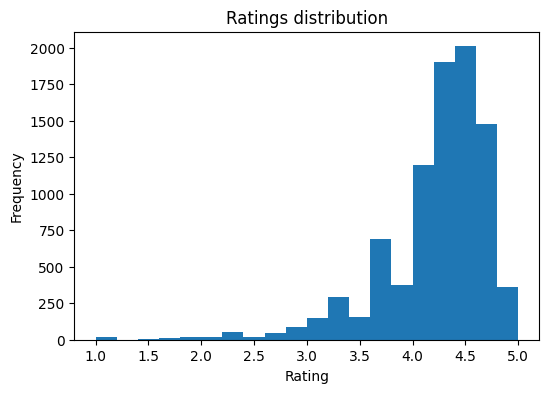

In [22]:
plt.figure(figsize=(6,4))
df['Rating'].dropna().plot(kind='hist', bins=20)
plt.title('Ratings distribution')
plt.xlabel('Rating')
plt.show()


Average rating per category

In [23]:
if 'Category' in df.columns:
    cat_rating = df.groupby('Category')['Rating'].mean().sort_values(ascending=False)
    print(cat_rating.head(15))


Category
EVENTS                 4.435556
EDUCATION              4.375969
ART_AND_DESIGN         4.358065
BOOKS_AND_REFERENCE    4.347458
PERSONALIZATION        4.333871
PARENTING              4.300000
GAME                   4.281285
BEAUTY                 4.278571
HEALTH_AND_FITNESS     4.261450
SOCIAL                 4.254918
SHOPPING               4.251485
WEATHER                4.244000
SPORTS                 4.225175
PRODUCTIVITY           4.201796
FAMILY                 4.191153
Name: Rating, dtype: float64


Top apps by installs

In [24]:
if 'Installs' in df.columns:
    top = df.sort_values(by='Installs', ascending=False).head(10)
    display(top[['App', 'Category', 'Installs', 'Rating', 'Reviews']])


,App,Category,Installs,Rating,Reviews
3454,Google Drive,PRODUCTIVITY,1000000000,4.4,2731171
865,Google Play Games,ENTERTAINMENT,1000000000,4.3,7165362
3523,Google Drive,PRODUCTIVITY,1000000000,4.4,2731211
2544,Facebook,SOCIAL,1000000000,4.1,78158306
2545,Instagram,SOCIAL,1000000000,4.5,66577313
464,Hangouts,COMMUNICATION,1000000000,4.0,3419513
3223,Maps - Navigate & Explore,TRAVEL_AND_LOCAL,1000000000,4.3,9235373
3816,Google News,NEWS_AND_MAGAZINES,1000000000,3.9,877643
4170,Google Drive,PRODUCTIVITY,1000000000,4.4,2728941
3896,Subway Surfers,GAME,1000000000,4.5,27711703


Relationship: Reviews vs Rating (scatter, with log scale on reviews)

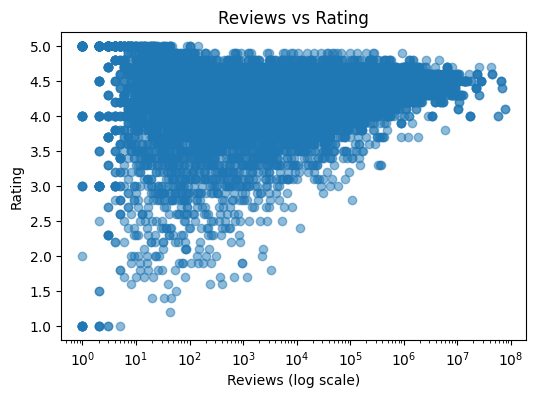

In [25]:
mask = (df['Reviews'] > 0) & (df['Rating'].notna())
plt.figure(figsize=(6,4))
plt.scatter(df.loc[mask, 'Reviews'], df.loc[mask, 'Rating'], alpha=0.5)
plt.xscale('log')
plt.xlabel('Reviews (log scale)')
plt.ylabel('Rating')
plt.title('Reviews vs Rating')
plt.show()


Paid apps: price distribution / count of paid vs free

In [26]:
if 'Type' in df.columns and 'Price' in df.columns:
    print(df['Type'].value_counts())
    df[df['Price'] > 0]['Price'].describe()


Type
Free    9591
Paid     765
0          1
Name: count, dtype: int64
